e**MAE: Mean Absolute Error**

The average of the absolute differences between predicted and actual values. Gives average error magnitude without considering direction.

**RMSE: Root Mean Squared Error**
The square root of the average of the squared differences between predicted and actual values. Penalizes larger errors more than smaller ones, providing a measure of error magnitude.


I can find the error of the datapoints and I can find the error of the interpolated heatmap.  For now I will start from the heatmap.

In [1]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

def assign_clusters_to_data(
    csv_path,
    eps_meters=2000,
    min_samples=3
):
    df = pd.read_csv(csv_path)

    coords = df[['Latitude', 'Longitude']].values
    coords_rad = np.radians(coords)

    kms_per_radian = 6371.0088
    eps = eps_meters / 1000.0 / kms_per_radian

    db = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine').fit(coords_rad)
    df['cluster'] = db.labels_

    # Overwrite the original file
    df.to_csv(csv_path, index=False)
    print(f"✅ Overwrote original file with clusters: {csv_path}")

    return df


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_mae_rmse_by_label_from_csv(predicted_csv_path, ground_truth_csv_path):
    # Load the CSVs
    pred_df = pd.read_csv(predicted_csv_path)
    gt_df = pd.read_csv(ground_truth_csv_path)

    # Ensure both dataframes have same structure
    assert all(col in pred_df.columns for col in ['x', 'y', 'label', 'value']), "Predicted CSV missing required columns"
    assert all(col in gt_df.columns for col in ['x', 'y', 'label', 'value']), "Ground truth CSV missing required columns"

    # Merge on coordinates
    merged = pd.merge(pred_df, gt_df, on=['x', 'y'], suffixes=('_pred', '_true'))

    # Initialize containers
    labels = np.arange(9)
    mae_per_label = []
    rmse_per_label = []

    for label in labels:
        subset = merged[merged['label_true'] == label]
        if not subset.empty:
            errors = subset['value_pred'] - subset['value_true']
            mae = np.mean(np.abs(errors))
            rmse = np.sqrt(np.mean(errors ** 2))
        else:
            mae = np.nan
            rmse = np.nan
        mae_per_label.append(mae)
        rmse_per_label.append(rmse)

    # Compute overall MAE and RMSE
    overall_mae = np.mean(np.abs(merged['value_pred'] - merged['value_true']))
    overall_rmse = np.sqrt(np.mean((merged['value_pred'] - merged['value_true']) ** 2))

    # Plot MAE
    plt.figure(figsize=(10, 5))
    plt.bar(labels, mae_per_label)
    plt.xlabel('Label')
    plt.ylabel('MAE')
    plt.title(f'MAE by Label (Overall MAE = {overall_mae:.4f})')
    plt.xticks(labels)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Plot RMSE
    plt.figure(figsize=(10, 5))
    plt.bar(labels, rmse_per_label)
    plt.xlabel('Label')
    plt.ylabel('RMSE')
    plt.title(f'RMSE by Label (Overall RMSE = {overall_rmse:.4f})')
    plt.xticks(labels)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    return mae_per_label, rmse_per_label, overall_mae, overall_rmse


In [3]:
import os
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize
from PIL import Image
import io
import base64
from scipy.interpolate import griddata
from sklearn.cluster import DBSCAN
import folium
from folium.raster_layers import ImageOverlay
from folium.plugins import MarkerCluster


def interpolate_clusters_heatmap(
    csv_path,
    value_column='mode',
    interpolation_method='idw',
    method_params=None,
    eps_meters=2000,
    min_samples=3,
    buffer_m=300,
    grid_res=300,
    save_results=False,
    output_folder="../resources",
    save_name=None
):
    if method_params is None:
        method_params = {}

    valid_methods = ['idw', 'nearest', 'linear', 'cubic', 'spline', 'kriging']
    if interpolation_method not in valid_methods:
        raise ValueError(f"Interpolation method must be one of: {', '.join(valid_methods)}")

    if save_results and not save_name:
        raise ValueError("You must specify save_name when save_results is True.")

    df = pd.read_csv(csv_path)
    coords = df[['Latitude', 'Longitude']].values
    coords_rad = np.radians(coords)

    kms_per_radian = 6371.0088
    eps = eps_meters / (1000.0 * kms_per_radian)
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine').fit(coords_rad)
    df['cluster'] = db.labels_

    center = [df['Latitude'].mean(), df['Longitude'].mean()]
    fmap = folium.Map(location=center, zoom_start=14, tiles='cartodb positron')
    marker_cluster = MarkerCluster().add_to(fmap)

    for _, row in df.iterrows():
        popup = folium.Popup(f"""
            <b>Filename:</b> {row['Filename']}<br>
            <b>Lat:</b> {row['Latitude']:.5f}, <b>Lon:</b> {row['Longitude']:.5f}<br>
            <b>{value_column}:</b> {row[value_column]}<br>
        """, max_width=300)
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=popup,
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(marker_cluster)

    all_interp_data = []

    for cluster_id in sorted(df['cluster'].unique()):
        if cluster_id == -1:
            continue

        cluster_df = df[df['cluster'] == cluster_id]
        lats = cluster_df['Latitude'].values
        lons = cluster_df['Longitude'].values
        values = cluster_df[value_column].values

        buffer_deg = buffer_m / 111_000.0
        min_lat, max_lat = lats.min() - buffer_deg, lats.max() + buffer_deg
        min_lon, max_lon = lons.min() - buffer_deg, lons.max() + buffer_deg

        grid_lon = np.linspace(min_lon, max_lon, grid_res)
        grid_lat = np.linspace(min_lat, max_lat, grid_res)
        grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)

        try:
            if interpolation_method == 'idw':
                power = method_params.get('power', 2)

                def idw(x, y, z, xi, yi, power=2):
                    dist = np.sqrt((x[:, None, None] - xi[None, :, :])**2 +
                                   (y[:, None, None] - yi[None, :, :])**2)
                    dist[dist == 0] = 1e-10
                    weights = 1 / dist**power
                    return np.sum(weights * z[:, None, None], axis=0) / np.sum(weights, axis=0)

                interpolated = idw(lons, lats, values, grid_x, grid_y, power=power)

            elif interpolation_method in ['nearest', 'linear', 'cubic']:
                interpolated = griddata(
                    points=(lons, lats),
                    values=values,
                    xi=(grid_x, grid_y),
                    method=interpolation_method
                )

            elif interpolation_method == 'spline':
                from scipy.interpolate import Rbf
                function = method_params.get('function', 'thin_plate')
                epsilon = method_params.get('epsilon', None)
                rbf = Rbf(lons, lats, values, function=function, epsilon=epsilon)
                interpolated = rbf(grid_x, grid_y)

            elif interpolation_method == 'kriging':
                from pykrige.ok import OrdinaryKriging
                variogram_model = method_params.get('variogram_model', 'linear')
                nlags = method_params.get('nlags', 6)
                weight = method_params.get('weight', False)
                OK = OrdinaryKriging(
                    lons, lats, values,
                    variogram_model=variogram_model,
                    nlags=nlags,
                    weight=weight,
                    verbose=False,
                    enable_plotting=False
                )
                interpolated, _ = OK.execute('grid', grid_lon, grid_lat)

            flat_lats = grid_y.flatten()
            flat_lons = grid_x.flatten()
            flat_values = interpolated.flatten()
            interp_df = pd.DataFrame({
                'Latitude': flat_lats,
                'Longitude': flat_lons,
                'Interpolated': flat_values,
                'Cluster': cluster_id
            })

            all_interp_data.append(interp_df)

            norm = Normalize(vmin=np.nanmin(interpolated), vmax=np.nanmax(interpolated))
            cmap = cm.viridis
            rgba_image = cmap(norm(interpolated))
            rgb_image = (rgba_image[:, :, :3] * 255).astype(np.uint8)
            img = Image.fromarray(rgb_image)

            buffer = io.BytesIO()
            img.save(buffer, format="PNG")
            encoded = base64.b64encode(buffer.getvalue()).decode("utf-8")
            data_url = f"data:image/png;base64,{encoded}"

            bounds = [[min_lat, min_lon], [max_lat, max_lon]]
            ImageOverlay(image=data_url, bounds=bounds, opacity=0.6).add_to(fmap)

        except Exception as e:
            print(f"⚠️ Could not interpolate cluster {cluster_id}: {type(e).__name__}: {e}")

    final_interp_df = pd.concat(all_interp_data, ignore_index=True)

    if save_results:
        os.makedirs(output_folder, exist_ok=True)
        final_csv_path = os.path.join(output_folder, f"{save_name}.csv")
        final_html_path = os.path.join(output_folder, f"{save_name}.html")
        final_interp_df.to_csv(final_csv_path, index=False)
        fmap.save(final_html_path)
        print(f"✅ Interpolated values saved to: {final_csv_path}")
        print(f"✅ HTML map saved to: {final_html_path}")

    return final_interp_df, fmap


In [4]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata, Rbf
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import DBSCAN

def loocv_on_input_cluster(df, value_column, interpolation_method):
    X = df[['Longitude', 'Latitude']].values
    y = df[value_column].values

    y_true = []
    y_pred = []

    for i in range(len(X)):
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i)
        x_test = X[i]
        y_test = y[i]

        try:
            if interpolation_method == 'idw':
                power = 2
                dist = np.sqrt(np.sum((X_train - x_test) ** 2, axis=1))
                dist[dist == 0] = 1e-10
                weights = 1 / dist ** power
                pred = np.sum(weights * y_train) / np.sum(weights)

            elif interpolation_method in ['nearest', 'linear', 'cubic']:
                pred = griddata(X_train, y_train, x_test, method=interpolation_method)

            elif interpolation_method == 'spline':
                rbf = Rbf(X_train[:, 0], X_train[:, 1], y_train, function='thin_plate')
                pred = rbf(x_test[0], x_test[1])

            elif interpolation_method == 'kriging':
                OK = OrdinaryKriging(
                    X_train[:, 0], X_train[:, 1], y_train,
                    variogram_model='linear',
                    nlags=6,
                    weight=False,
                    verbose=False,
                    enable_plotting=False
                )
                pred, _ = OK.execute('points', np.array([x_test[0]]), np.array([x_test[1]]))
                pred = pred[0]

            y_true.append(y_test)
            y_pred.append(pred)

        except Exception:
            y_true.append(np.nan)
            y_pred.append(np.nan)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    mae = mean_absolute_error(y_true[mask], y_pred[mask])
    rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))

    return mae, rmse


# Load the CSV
csv_path = "../resources/mask_aggregations.csv"
df_all = pd.read_csv(csv_path)

# Cluster using DBSCAN
coords = df_all[['Latitude', 'Longitude']].values
coords_rad = np.radians(coords)
kms_per_radian = 6371.0088
eps_meters = 2000
eps = eps_meters / (1000.0 * kms_per_radian)
db = DBSCAN(eps=eps, min_samples=3, metric='haversine').fit(coords_rad)
df_all['cluster'] = db.labels_

# Get the largest cluster
largest_cluster_id = df_all['cluster'].value_counts().idxmax()
df_cluster = df_all[df_all['cluster'] == largest_cluster_id]

# Define interpolation methods and value columns
methods = ['idw', 'nearest', 'linear', 'cubic', 'spline', 'kriging']
value_columns = ['Mode', 'Weighted Average']

# Initialize result tables
mae_results = pd.DataFrame(index=value_columns, columns=methods)
rmse_results = pd.DataFrame(index=value_columns, columns=methods)

# Evaluate LOOCV MAE and RMSE for each combination
for value_col in value_columns:
    for method in methods:
        try:
            mae, rmse = loocv_on_input_cluster(df_cluster, value_col, method)
            mae_results.loc[value_col, method] = mae
            rmse_results.loc[value_col, method] = rmse
        except Exception:
            mae_results.loc[value_col, method] = np.nan
            rmse_results.loc[value_col, method] = np.nan

from IPython.display import display

# Display the DataFrames in a styled format
display(mae_results.style.set_caption("LOOCV MAE Table (Largest Cluster)"))
display(rmse_results.style.set_caption("LOOCV RMSE Table (Largest Cluster)"))


,idw,nearest,linear,cubic,spline,kriging
Mode,2.667126,nan,nan,nan,4.159394,2.658976
Weighted Average,1.604084,nan,nan,nan,2.723779,1.567672


,idw,nearest,linear,cubic,spline,kriging
Mode,3.169813,nan,nan,nan,6.259399,2.966786
Weighted Average,1.977158,nan,nan,nan,4.516895,1.839058


✅ Interpolated values saved to: ../resources/pred_heatmap_mode_kriging.csv
✅ HTML map saved to: ../resources/pred_heatmap_mode_kriging.html
    Latitude  Longitude  Interpolated  Cluster
0  36.191632  36.133403       4.39823        0
1  36.191632  36.133546       4.39823        0
2  36.191632  36.133689       4.39823        0
3  36.191632  36.133832       4.39823        0
4  36.191632  36.133975       4.39823        0



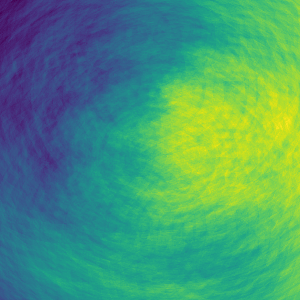
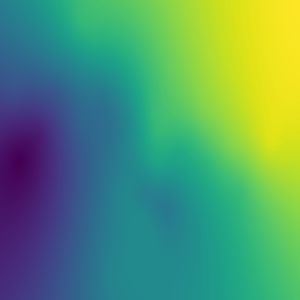
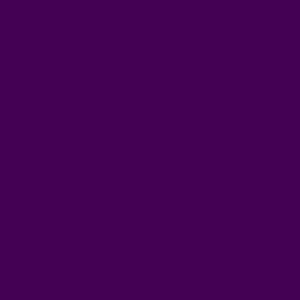
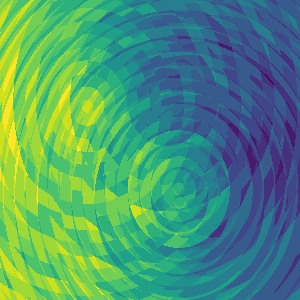
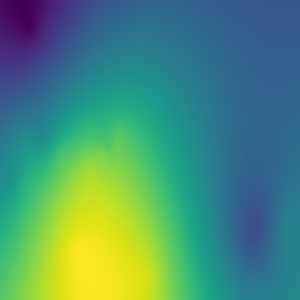
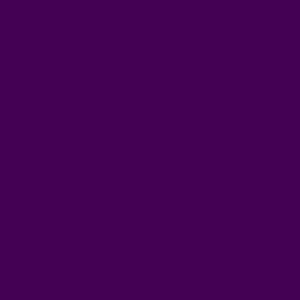
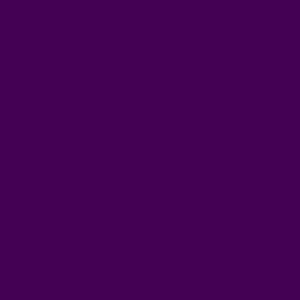
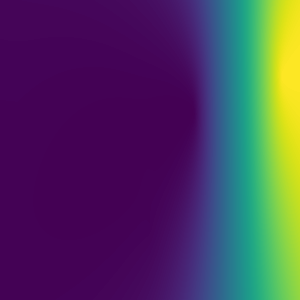
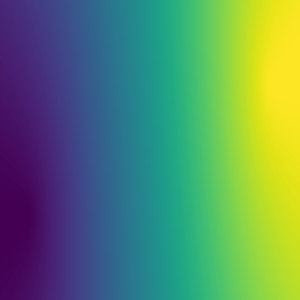

In [5]:
# Make sure the function interpolate_clusters_heatmap is already defined or imported

# Define path to CSV on your local GitHub repo clone
pred_csv_path = "../resources/mask_aggregations.csv"
output_path = "../resources"

# Run the heatmap interpolation using Kriging on 'Mode'
interp_pred, fmap = interpolate_clusters_heatmap(
    csv_path=pred_csv_path,
    value_column='Mode',
    interpolation_method='kriging',
    method_params={
        'variogram_model': 'linear',  # You can also try: 'gaussian', 'spherical', 'exponential'
        'nlags': 6,
        'weight': False
    },
    save_results=True,
    output_folder=output_path,
    save_name="pred_heatmap_mode_kriging"
)

# Display first few interpolated results
print(interp_pred.head())

# Show interactive map (in notebook or Jupyter Lab)
fmap


✅ Interpolated values saved to: ../resources/gt_heatmap_mode_kriging.csv
✅ HTML map saved to: ../resources/gt_heatmap_mode_kriging.html
    Latitude  Longitude  Interpolated  Cluster
0  36.191632  36.133403      4.362745        0
1  36.191632  36.133546      4.363088        0
2  36.191632  36.133689      4.363432        0
3  36.191632  36.133832      4.363779        0
4  36.191632  36.133975      4.364128        0



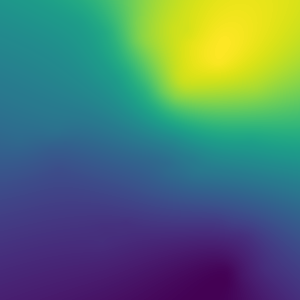
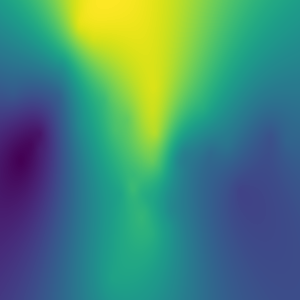
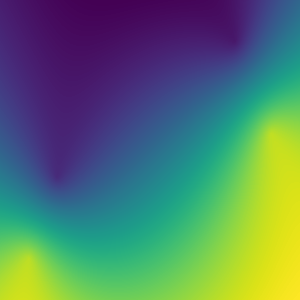
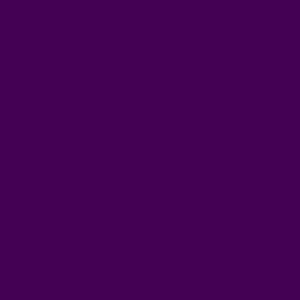
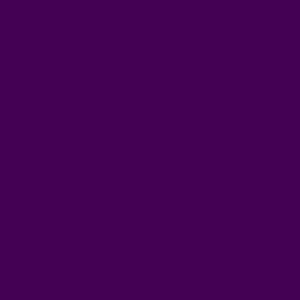
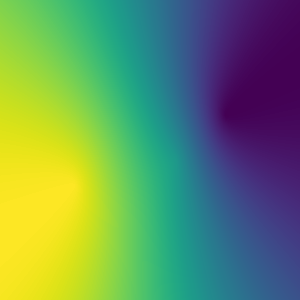
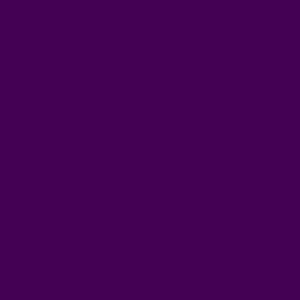
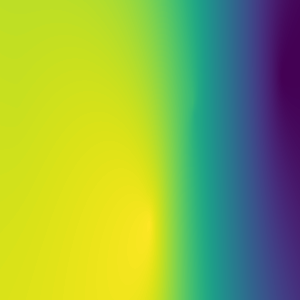
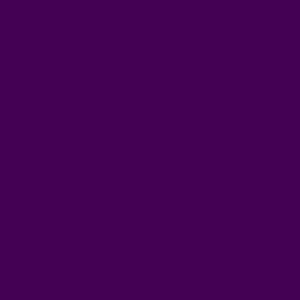

In [6]:
# Make sure the function interpolate_clusters_heatmap is already defined or imported

# Define path to CSV on your local GitHub repo clone
gt_csv_path = "../resources/gt_mask_aggregations.csv"
output_path = "../resources"

# Run the heatmap interpolation using Kriging on 'Mode'
interp_gt, fmap = interpolate_clusters_heatmap(
    csv_path=gt_csv_path,
    value_column='Mode',
    interpolation_method='kriging',
    method_params={
        'variogram_model': 'linear',  # You can also try: 'gaussian', 'spherical', 'exponential'
        'nlags': 6,
        'weight': False
    },
    save_results=True,  # Do not save yet — just inspect first
    output_folder=output_path,
    save_name="gt_heatmap_mode_kriging"
)

# Display first few interpolated results
print(interp_gt.head())

# Show interactive map (in notebook or Jupyter Lab)
fmap

In [7]:
import pandas as pd
import numpy as np
import folium
from folium.raster_layers import ImageOverlay
from matplotlib import cm
from matplotlib.colors import Normalize, TwoSlopeNorm
from PIL import Image
import os

def generate_error_map(
    pred_csv_path,
    gt_csv_path,
    error_type='absolute',  # 'absolute', 'relative', or 'raw'
    cluster_id=None,
    save_results=False,
    output_folder=None,
    save_name=None
):
    assert error_type in ['absolute', 'relative', 'raw'], "error_type must be 'absolute', 'relative', or 'raw'"

    # Load predicted and ground truth CSVs
    pred_df = pd.read_csv(pred_csv_path)
    gt_df = pd.read_csv(gt_csv_path)

    # Merge on coordinates
    merged = pd.merge(pred_df, gt_df, on=['Latitude', 'Longitude'], suffixes=('_pred', '_gt'))

    # Ensure unified 'Cluster' column
    if 'Cluster_pred' in merged.columns:
        merged['Cluster'] = merged['Cluster_pred']
    elif 'Cluster_gt' in merged.columns:
        merged['Cluster'] = merged['Cluster_gt']
    else:
        raise KeyError("No 'Cluster' column found in either CSV.")
    merged.drop(columns=['Cluster_pred', 'Cluster_gt'], inplace=True, errors='ignore')

    # Optional cluster filtering
    if cluster_id is not None:
        merged = merged[merged['Cluster'] == cluster_id]

    # Calculate error
    if error_type == 'absolute':
        merged['Error'] = np.abs(merged['Interpolated_pred'] - merged['Interpolated_gt'])
    elif error_type == 'relative':
        with np.errstate(divide='ignore', invalid='ignore'):
            merged['Error'] = np.abs(merged['Interpolated_pred'] - merged['Interpolated_gt']) / merged['Interpolated_gt']
            merged['Error'] = merged['Error'].replace([np.inf, -np.inf], np.nan)
    else:  # raw
        merged['Error'] = merged['Interpolated_pred'] - merged['Interpolated_gt']

    # Prepare map
    fmap = folium.Map(location=[merged['Latitude'].mean(), merged['Longitude'].mean()],
                      zoom_start=13, tiles='cartodb positron')

    for cid in sorted(merged['Cluster'].unique()):
        cluster = merged[merged['Cluster'] == cid]

        lats = np.unique(cluster['Latitude'])
        lons = np.unique(cluster['Longitude'])
        lats.sort()
        lons.sort()
        grid_lat, grid_lon = np.meshgrid(lats, lons, indexing='ij')
        error_grid = np.full_like(grid_lat, fill_value=np.nan, dtype=np.float64)

        coord_to_index = {(lat, lon): (i, j) for i, lat in enumerate(lats) for j, lon in enumerate(lons)}
        for _, row in cluster.iterrows():
            lat_idx, lon_idx = coord_to_index[(row['Latitude'], row['Longitude'])]
            error_grid[lat_idx, lon_idx] = row['Error']

        # Choose color normalization and colormap
        if error_type == 'raw':
            norm = TwoSlopeNorm(vcenter=0, vmin=np.nanmin(error_grid), vmax=np.nanmax(error_grid))
            cmap = cm.coolwarm
        else:
            norm = Normalize(vmin=np.nanmin(error_grid), vmax=np.nanmax(error_grid))
            cmap = cm.viridis

        rgba_error = cmap(norm(error_grid))
        rgb_error = (rgba_error[:, :, :3] * 255).astype(np.uint8)
        img_error = Image.fromarray(rgb_error)

        temp_path = f"/tmp/error_map_cluster_{cid}.png"
        img_error.save(temp_path)
        bounds = [[lats.min(), lons.min()], [lats.max(), lons.max()]]
        ImageOverlay(image=temp_path, bounds=bounds, opacity=0.6).add_to(fmap)

    # Save or return map
    if save_results:
        if not output_folder or not save_name:
            raise ValueError("Both output_folder and save_name must be specified if save_results is True.")
        os.makedirs(output_folder, exist_ok=True)
        save_path = os.path.join(output_folder, f"{save_name}.html")
        fmap.save(save_path)
        print(f"✅ Error map saved to: {save_path}")
    else:
        return fmap



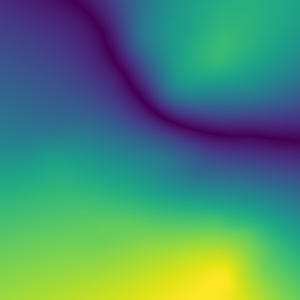
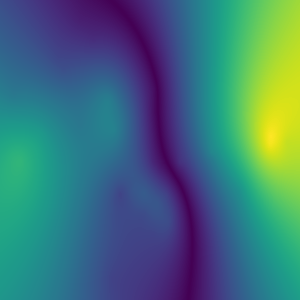
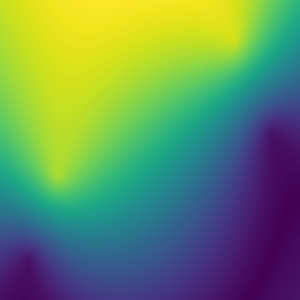
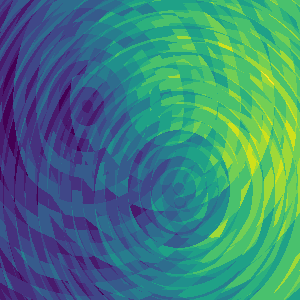
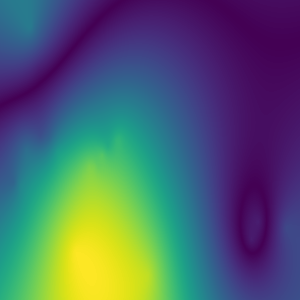
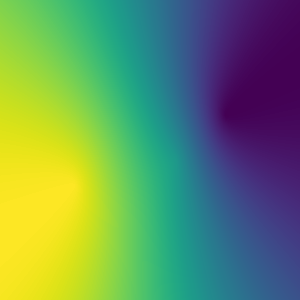
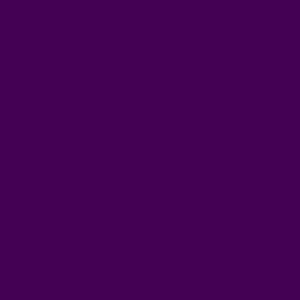
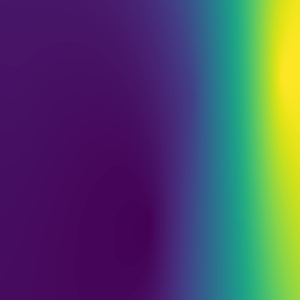
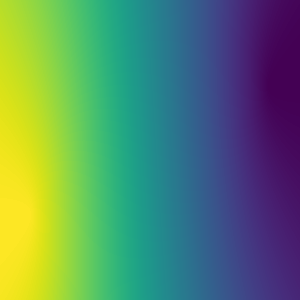

In [9]:
generate_error_map(
    pred_csv_path="../resources/pred_heatmap_mode_kriging.csv",
    gt_csv_path="../resources/gt_heatmap_mode_kriging.csv",
    error_type="absolute",
    save_results=False
)


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_mae_rmse_by_label_from_csv(predicted_csv_path, ground_truth_csv_path):
    # Load the CSVs
    pred_df = pd.read_csv(predicted_csv_path)
    gt_df = pd.read_csv(ground_truth_csv_path)

    # Merge on coordinates
    merged = pd.merge(
        pred_df,
        gt_df,
        on=['Latitude', 'Longitude'],
        suffixes=('_pred', '_true')
    )

    # Validate required columns exist
    required_cols = ['Mode_pred', 'Mode_true', 'Weighted Average_pred', 'Weighted Average_true']
    for col in required_cols:
        if col not in merged.columns:
            raise ValueError(f"Missing required column: {col}")

    labels = np.arange(9)  # Assuming Mode values are in range 0–8
    mae_per_label = []
    rmse_per_label = []

    for label in labels:
        subset = merged[merged['Mode_true'] == label]
        if not subset.empty:
            pred_vals = subset['Weighted Average_pred']
            true_vals = subset['Weighted Average_true']
            errors = pred_vals - true_vals
            mae = np.mean(np.abs(errors))
            rmse = np.sqrt(np.mean(errors**2))
        else:
            mae = np.nan
            rmse = np.nan
        mae_per_label.append(mae)
        rmse_per_label.append(rmse)

    # Overall scores
    overall_mae = np.mean(np.abs(merged['Weighted Average_pred'] - merged['Weighted Average_true']))
    overall_rmse = np.sqrt(np.mean((merged['Weighted Average_pred'] - merged['Weighted Average_true'])**2))

    # Plot MAE
    plt.figure(figsize=(10, 5))
    plt.bar(labels, mae_per_label)
    plt.xlabel('True Damage Class (Mode)')
    plt.ylabel('MAE of Weighted Average')
    plt.title(f'MAE by True Mode Label (Overall MAE = {overall_mae:.4f})')
    plt.xticks(labels)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Plot RMSE
    plt.figure(figsize=(10, 5))
    plt.bar(labels, rmse_per_label)
    plt.xlabel('True Damage Class (Mode)')
    plt.ylabel('RMSE of Weighted Average')
    plt.title(f'RMSE by True Mode Label (Overall RMSE = {overall_rmse:.4f})')
    plt.xticks(labels)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    return mae_per_label, rmse_per_label, overall_mae, overall_rmse


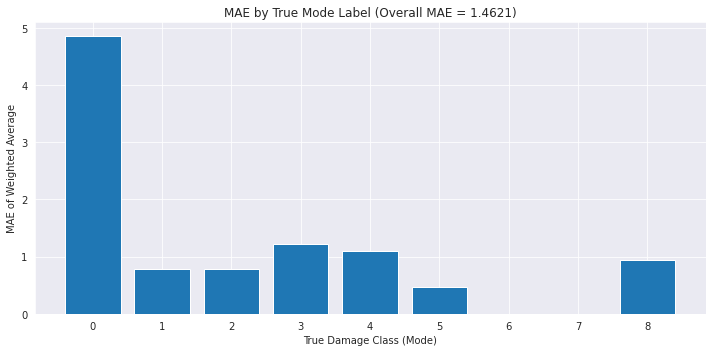

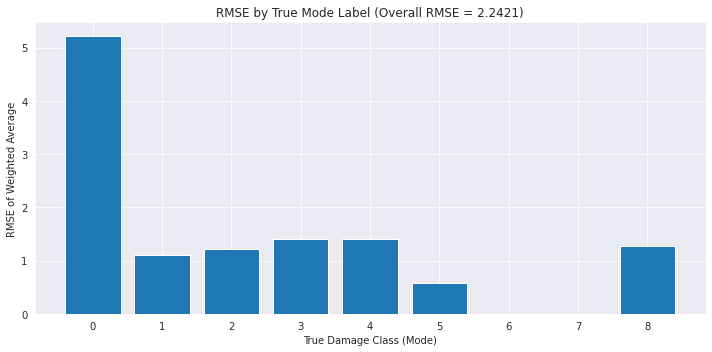

([4.855456406076606,
  0.787256665720413,
  0.7847602101014728,
  1.213594776092563,
  1.1064323133763048,
  0.4771973403453777,
  nan,
  nan,
  0.9429039065535445],
 [5.211066704109239,
  1.0988019130066462,
  1.217537961129918,
  1.3968876312878622,
  1.4036992192738609,
  0.5867228522282049,
  nan,
  nan,
  1.2713597490166244],
 1.4620645145385214,
 2.242126898932873)

In [11]:
pred_csv_path="../resources/mask_aggregations.csv"
gt_csv_path="../resources/gt_mask_aggregations.csv"
calculate_mae_rmse_by_label_from_csv(pred_csv_path, gt_csv_path)


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def evaluate_heatmap_error(
    pred_df,
    gt_df,
    rounding_method='floor',  # 'floor' or 'ceil'
    cluster_id=None            # None for all, or specific cluster number
):
    assert rounding_method in ['floor', 'ceil'], "rounding_method must be 'floor' or 'ceil'"

    # Merge predicted and ground truth data on coordinates
    merged = pd.merge(pred_df, gt_df, on=['Latitude', 'Longitude'], suffixes=('_pred', '_true'))

    # Use a unified Cluster column (assumes they match by coord)
    merged['Cluster'] = merged['Cluster_pred'] if 'Cluster_pred' in merged else merged['Cluster_true']
    merged.drop(columns=['Cluster_pred', 'Cluster_true'], errors='ignore', inplace=True)

    # Optional: filter by cluster
    if cluster_id is not None:
        merged = merged[merged['Cluster'] == cluster_id]

    # Apply rounding to interpolated values
    if rounding_method == 'floor':
        merged['Label_pred'] = np.floor(merged['Interpolated_pred']).astype(int)
        merged['Label_true'] = np.floor(merged['Interpolated_true']).astype(int)
    else:
        merged['Label_pred'] = np.ceil(merged['Interpolated_pred']).astype(int)
        merged['Label_true'] = np.ceil(merged['Interpolated_true']).astype(int)

    # Initialize per-label error containers
    labels = np.arange(9)
    mae_per_label = []
    rmse_per_label = []

    for label in labels:
        subset = merged[merged['Label_true'] == label]
        if not subset.empty:
            errors = subset['Label_pred'] - label
            mae = np.mean(np.abs(errors))
            rmse = np.sqrt(np.mean(errors ** 2))
        else:
            mae = np.nan
            rmse = np.nan
        mae_per_label.append(mae)
        rmse_per_label.append(rmse)

    # Compute overall error
    all_errors = merged['Label_pred'] - merged['Label_true']
    overall_mae = np.mean(np.abs(all_errors))
    overall_rmse = np.sqrt(np.mean(all_errors ** 2))

    # Plot MAE
    plt.figure(figsize=(10, 5))
    plt.bar(labels, mae_per_label, color='skyblue')
    plt.xlabel('True Label')
    plt.ylabel('MAE')
    plt.title(f'MAE by Label (Overall MAE = {overall_mae:.4f})')
    plt.xticks(labels)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    # Plot RMSE
    plt.figure(figsize=(10, 5))
    plt.bar(labels, rmse_per_label, color='skyblue')
    plt.xlabel('True Label')
    plt.ylabel('RMSE')
    plt.title(f'RMSE by Label (Overall RMSE = {overall_rmse:.4f})')
    plt.xticks(labels)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    return mae_per_label, rmse_per_label, overall_mae, overall_rmse




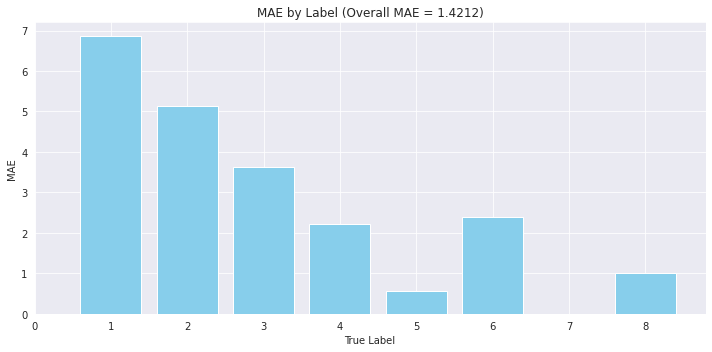

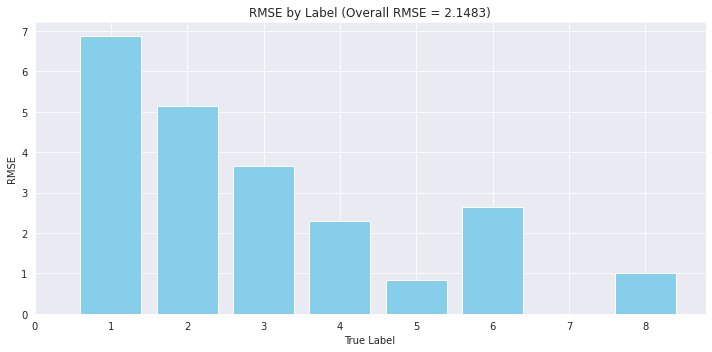

([nan,
  6.85815991237678,
  5.132174223856209,
  3.6288870008496175,
  2.2110719874804383,
  0.564517508285761,
  2.383437042375191,
  0.0,
  1.0],
 [nan,
  6.867028386492817,
  5.143337093990467,
  3.661123226487223,
  2.3050346339126397,
  0.8456967797336121,
  2.646812683326705,
  0.0,
  1.0],
 1.421185185185185,
 2.1482631514554344)

In [13]:
# Assuming you have already loaded:
# predicted_df = pd.read_csv("predicted_heatmap.csv")
# ground_truth_df = pd.read_csv("ground_truth_heatmap.csv")

evaluate_heatmap_error(
    interp_pred,
  interp_gt,
    rounding_method='ceil',
    cluster_id=None  # or e.g. cluster_id=3
)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_point_error_cdf(
    gt_csv_path,
    pred_csv_path,
    value_column='Weighted Average'  # or 'Mode'
):
    """
    Loads predicted and ground truth CSVs, merges them on Latitude/Longitude,
    computes mean absolute error per location, and plots a CDF.
    """
    # Load CSVs
    pred_df = pd.read_csv(pred_csv_path)
    gt_df = pd.read_csv(gt_csv_path)

    # Merge on coordinates
    merged = pd.merge(
        pred_df,
        gt_df,
        on=['Latitude', 'Longitude'],
        suffixes=('_pred', '_true')
    )

    # Group by AQM station (Latitude + Longitude)
    grouped = merged.groupby(['Latitude', 'Longitude'])

    # Compute MAE per station
    station_mae = grouped.apply(
        lambda g: np.mean(np.abs(g[f"{value_column}_pred"] - g[f"{value_column}_true"]))
    )

    # Sort for CDF
    sorted_errors = np.sort(station_mae.values)
    cdf_y = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(sorted_errors, cdf_y, marker='o', linestyle='-')
    plt.xlabel(f'Mean Absolute Error ({value_column})')
    plt.ylabel('Cumulative Fraction of Stations')
    plt.title(f'CDF of Mean Absolute Errors by Station ({value_column})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return merged, station_mae



/tmp/ipykernel_831182/1099889981.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  station_mae = grouped.apply(


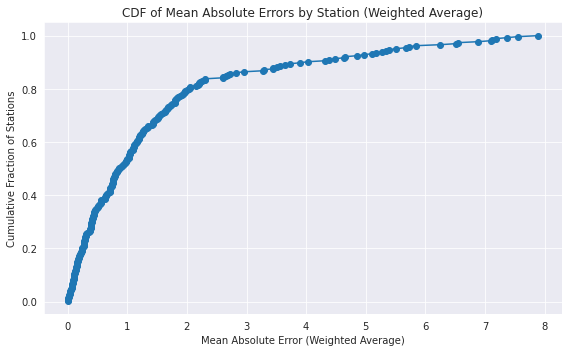

In [15]:
merged_df, station_mae = plot_point_error_cdf(
    gt_csv_path=gt_csv_path,
    pred_csv_path=pred_csv_path,
    value_column="Weighted Average"  # or "Mode"
)


/tmp/ipykernel_831182/1099889981.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  station_mae = grouped.apply(


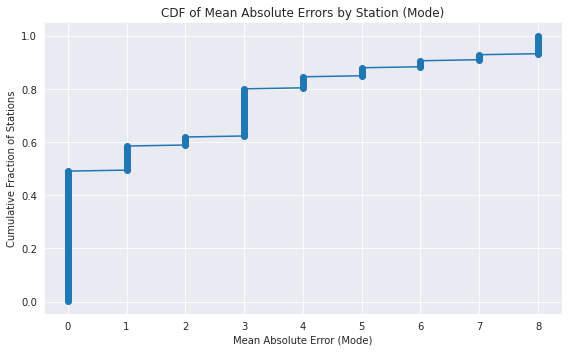

In [16]:
merged_df, station_mae = plot_point_error_cdf(
    gt_csv_path=gt_csv_path,
    pred_csv_path=pred_csv_path,
    value_column="Mode"  # or "Mode"
)

In [17]:
interp_pred=pd.read_csv("../resources/pred_heatmap_mode_kriging.csv")
interp_gt=pd.read_csv("../resources/gt_heatmap_mode_kriging.csv")

interp_pred.head()

,Latitude,Longitude,Interpolated,Cluster
0,36.191632,36.133403,4.39823,0
1,36.191632,36.133546,4.39823,0
2,36.191632,36.133689,4.39823,0
3,36.191632,36.133832,4.39823,0
4,36.191632,36.133975,4.39823,0


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_error_distribution(pred_csv, gt_csv, value_type='Weighted Average', bins=20):
    """
    Plots the distribution of prediction errors between predicted and ground truth values.

    Parameters:
    - pred_csv: str, path to the CSV with predictions.
    - gt_csv: str, path to the CSV with ground truth.
    - value_type: str, either "Mode" or "Weighted Average".
    - bins: int, number of bins in the histogram (only for continuous values).
    """

    # Load prediction and ground truth CSVs
    pred_df = pd.read_csv(pred_csv)
    gt_df = pd.read_csv(gt_csv)

    print(f"Loaded {len(pred_df)} predictions and {len(gt_df)} ground truth rows.")

    # Normalize filenames: strip, lowercase, and remove extension
    pred_df['BaseName'] = pred_df['Filename'].apply(lambda x: os.path.splitext(x.strip().lower())[0])
    gt_df['BaseName'] = gt_df['Filename'].apply(lambda x: os.path.splitext(x.strip().lower())[0])

    # Merge on BaseName
    merged_df = pd.merge(pred_df, gt_df, on='BaseName', suffixes=('_pred', '_gt'))

    # Debug: Show merge result
    print(f"Merged dataframe has {len(merged_df)} rows.")
    print("Available columns after merge:", merged_df.columns.tolist())

    # Validate value_type
    if value_type not in ["Mode", "Weighted Average"]:
        raise ValueError("value_type must be either 'Mode' or 'Weighted Average'")

    # Drop rows with missing values in the relevant columns
    pred_col = f"{value_type}_pred"
    gt_col = f"{value_type}_gt"
    merged_df = merged_df.dropna(subset=[pred_col, gt_col])

    # Debug: Show sample values
    print(f"Sample {value_type} values:\n", merged_df[[pred_col, gt_col]].head())

    # Compute prediction errors
    errors = merged_df[pred_col] - merged_df[gt_col]
    mean_bias = errors.mean()

    # Debug: Show error stats
    print(f"Mean Bias: {mean_bias:.4f}")
    print(f"Standard Deviation: {errors.std():.4f}")
    print(f"Error Range: {errors.min():.4f} to {errors.max():.4f}")

    # Plot
    plt.figure(figsize=(10, 6))
    if value_type == 'Mode':
        # Discrete errors → bar plot
        error_counts = errors.value_counts().sort_index()
        sns.barplot(x=error_counts.index, y=error_counts.values, edgecolor='black')
        plt.xlabel("Prediction Error (Predicted Mode - True Mode)")
        plt.ylabel("Frequency")
    else:
        # Continuous errors → histogram with KDE
        sns.histplot(errors, bins=bins, kde=True, edgecolor='black')
        plt.xlabel("Prediction Error (Predicted - True Weighted Average)")
        plt.ylabel("Frequency")

    plt.title(f"Error Distribution for {value_type} (Bias: {mean_bias:.4f})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Loaded 265 predictions and 265 ground truth rows.
Merged dataframe has 265 rows.
Available columns after merge: ['Filename_pred', 'Latitude_pred', 'Longitude_pred', 'Mode_pred', 'Weighted Average_pred', 'BaseName', 'Filename_gt', 'Latitude_gt', 'Longitude_gt', 'Mode_gt', 'Weighted Average_gt']
Sample Mode values:
    Mode_pred  Mode_gt
0          8        5
1          8        8
2          2        2
3          8        5
4          5        5
Mean Bias: -0.1887
Standard Deviation: 3.1758
Error Range: -8.0000 to 7.0000


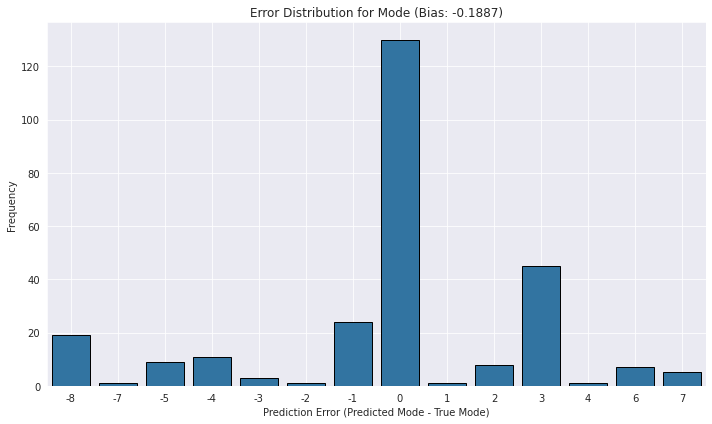

In [19]:
heatmap_pred_csv="../resources/mask_aggregations.csv"
heatmap_gt_csv="../resources/gt_mask_aggregations.csv"
plot_error_distribution(
   pred_csv=heatmap_gt_csv,
    gt_csv=heatmap_pred_csv,
    value_type='Mode',  # or 'Mode'
    bins=30
)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_bias_per_label(pred_csv, gt_csv, value_type='Mode'):
    """
    Plots the bias (mean prediction error) per ground truth label value.

    Parameters:
    - pred_csv: str, path to the CSV with predictions.
    - gt_csv: str, path to the CSV with ground truth.
    - value_type: str, either "Mode" or "Weighted Average".
    """

    if value_type not in ["Mode", "Weighted Average"]:
        raise ValueError("value_type must be 'Mode' or 'Weighted Average'")

    # Load and normalize filenames
    pred_df = pd.read_csv(pred_csv)
    gt_df = pd.read_csv(gt_csv)
    pred_df['BaseName'] = pred_df['Filename'].apply(lambda x: os.path.splitext(x.strip().lower())[0])
    gt_df['BaseName'] = gt_df['Filename'].apply(lambda x: os.path.splitext(x.strip().lower())[0])

    # Merge on BaseName
    merged_df = pd.merge(pred_df, gt_df, on='BaseName', suffixes=('_pred', '_gt'))

    pred_col = f"{value_type}_pred"
    gt_col = f"{value_type}_gt"

    # Drop missing values
    merged_df = merged_df.dropna(subset=[pred_col, gt_col])

    # Convert to numeric just in case
    merged_df[pred_col] = pd.to_numeric(merged_df[pred_col], errors='coerce')
    merged_df[gt_col] = pd.to_numeric(merged_df[gt_col], errors='coerce')
    merged_df = merged_df.dropna(subset=[pred_col, gt_col])

    # Compute error
    merged_df['error'] = merged_df[pred_col] - merged_df[gt_col]

    # Group by ground truth and compute bias
    bias_per_label = merged_df.groupby(gt_col)['error'].mean()

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=bias_per_label.index, y=bias_per_label.values, edgecolor='black')
    plt.xlabel(f"Ground Truth {value_type}")
    plt.ylabel("Mean Prediction Error (Bias)")
    plt.title(f"Prediction Bias per {value_type} Label")
    plt.axhline(0, color='black', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print bias values
    print(f"\nBias per {value_type} label:\n", bias_per_label.round(3))


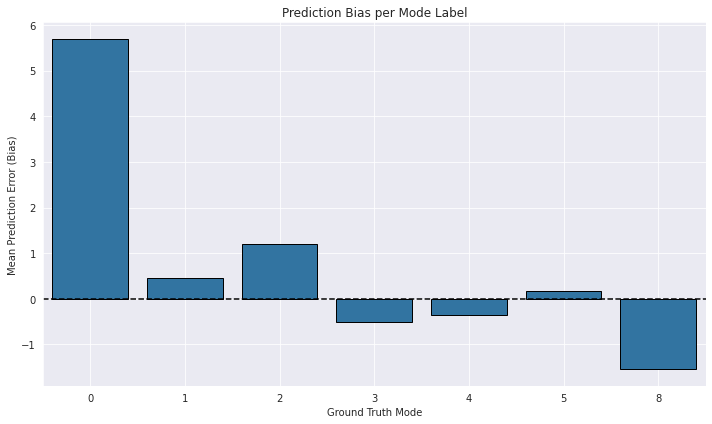


Bias per Mode label:
 Mode_gt
0    5.694
1    0.447
2    1.200
3   -0.500
4   -0.356
5    0.167
8   -1.545
Name: error, dtype: float64


In [21]:
plot_bias_per_label(
    pred_csv="../resources/mask_aggregations.csv",
    gt_csv="../resources/gt_mask_aggregations.csv",
    value_type="Mode"  # or "Weighted Average"
)
